<a href="https://colab.research.google.com/github/JaZz-9/Kaggle-Notebooks/blob/master/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle Setup


In [1]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

# Upload kaggle API key file
uploaded = files.upload()


Saving kaggle.json to kaggle (2).json


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c titanic

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


## Data Exploration

In [3]:
!ls

 gender_submission.csv	'kaggle (2).json'   sample_data   train.csv
'kaggle (1).json'	 kaggle.json	    test.csv


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [48]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [49]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [50]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [51]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [52]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [53]:
total = train.isnull().sum().sort_values(ascending = False)
total

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [54]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='90')
    fig=sns.barplot(ms.index, ms["Percent"],color="green",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    return ms
    

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


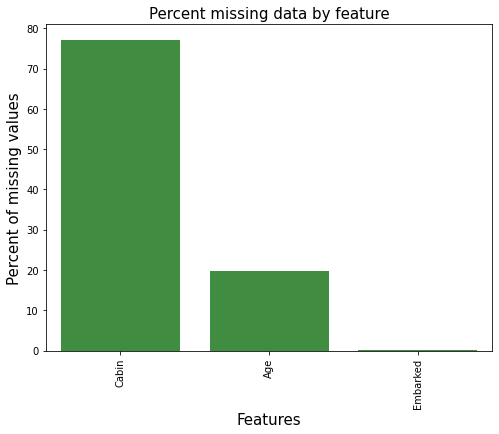

In [55]:
missingdata(train)

,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


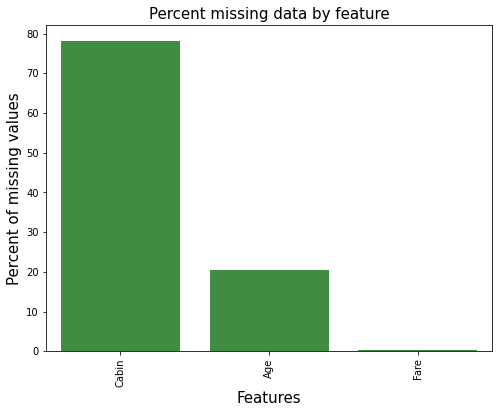

In [56]:
missingdata(test)

In [57]:
print(train['Age'].median(), test['Age'].median())
print(train['Embarked'].mode()[0], test['Embarked'].mode()[0])

28.0 27.0
S S


In [58]:
##Dropping cabin column as more than 75% misiing in both train and test coumn

train.drop(['Cabin'], axis=1, inplace=True)
test.drop(['Cabin'], axis=1, inplace=True)

## filling age ad embark with median

train['Age'].fillna(train['Age'].median(), inplace=True)
test['Age'].fillna(test['Age'].median(), inplace=True)

train['Embarked'].fillna(train['Embarked'].mode()[0], inplace = True)
test['Embarked'].fillna(test['Embarked'].mode()[0], inplace = True)


## Feature Enginnering

In [59]:
train = train
test = test

In [60]:
## combine test and train as single to apply some function
all_data=[train, test]

In [61]:
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [62]:
train['Fare'].min()

0.0

In [63]:
## create bin for fare features
for dataset in all_data:
    dataset['Fare_bin'] = pd.cut(dataset['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare',
                                                                                      'Average_fare','high_fare'])

In [64]:
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [65]:
## Age min = 0.45, max = 80; can be divided into several groups as young-adults might get les prefrence compared to kids and elders
## create bin for age features
for dataset in all_data:
    dataset['Age_bin'] = pd.cut(dataset['Age'], bins=[0,2,9,18,30,55,120], labels=['infants','kids', 'teenagers',
                                                                                      'Adults','Working', 'Elders'])

In [66]:
dataset

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Fare_bin,Age_bin
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,1,Low_fare,Working
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,2,Low_fare,Working
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,1,median_fare,Elders
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,1,median_fare,Adults
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,3,median_fare,Adults
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,27.0,0,0,A.5. 3236,8.0500,S,1,median_fare,Adults
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,1,high_fare,Working
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,1,Low_fare,Working
416,1308,3,"Ware, Mr. Frederick",male,27.0,0,0,359309,8.0500,S,1,median_fare,Adults


In [67]:
import re
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [68]:
for dataset in all_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    print(dataset['Title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


In [69]:
import re
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in all_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [70]:
train['Title']

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886    Rare
887    Miss
888    Miss
889      Mr
890      Mr
Name: Title, Length: 891, dtype: object

In [71]:
Id = test['PassengerId']
for dataset in all_data:
  dataset.drop(['Name', 'Age', 'Ticket', 'Fare', 'PassengerId'], axis=1, inplace = True)

In [72]:
train.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,FamilySize,Fare_bin,Age_bin,Title
0,0,3,male,1,0,S,2,Low_fare,Adults,Mr
1,1,1,female,1,0,C,2,high_fare,Working,Mrs
2,1,3,female,0,0,S,1,median_fare,Adults,Miss
3,1,1,female,1,0,S,2,high_fare,Working,Mrs
4,0,3,male,0,0,S,1,median_fare,Working,Mr


In [29]:
test.head()

,Pclass,Sex,SibSp,Parch,Embarked,FamilySize,Fare_bin,Age_bin,Title
0,3,male,0,0,Q,1,Low_fare,Working,Mr
1,3,female,1,0,S,2,Low_fare,Working,Mrs
2,2,male,0,0,Q,1,median_fare,Elders,Mr
3,3,male,0,0,S,1,median_fare,Adults,Mr
4,3,female,1,1,S,3,median_fare,Adults,Mrs


In [73]:
train_df = pd.get_dummies(train, columns = ['Sex', 'Pclass', 'Title', 'Embarked', 'Fare_bin', 'Age_bin'], prefix = ['Sex', 'Pclass', 'Title', 'Embarked', 'Fare_bin', 'Age_bin'])

test_df = pd.get_dummies(test, columns = ['Sex', 'Pclass', 'Title', 'Embarked', 'Fare_bin', 'Age_bin'], prefix = ['Sex', 'Pclass', 'Title', 'Embarked', 'Fare_bin', 'Age_bin'])

In [74]:
train_df.describe()

,Survived,SibSp,Parch,FamilySize,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_C,Embarked_Q,Embarked_S,Fare_bin_Low_fare,Fare_bin_median_fare,Fare_bin_Average_fare,Fare_bin_high_fare,Age_bin_infants,Age_bin_kids,Age_bin_teenagers,Age_bin_Adults,Age_bin_Working,Age_bin_Elders
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,0.523008,0.381594,1.904602,0.352413,0.647587,0.242424,0.206510,0.551066,0.044893,0.207632,0.580247,0.141414,0.025814,0.188552,0.086420,0.725028,0.233446,0.243547,0.257015,0.206510,0.026936,0.042649,0.086420,0.501684,0.297419,0.044893
std,0.486592,1.102743,0.806057,1.613459,0.477990,0.477990,0.428790,0.405028,0.497665,0.207186,0.405840,0.493796,0.348644,0.158668,0.391372,0.281141,0.446751,0.423261,0.429463,0.437233,0.405028,0.161987,0.202177,0.281141,0.500278,0.457379,0.207186
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,8.000000,6.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [75]:
print(list(train_df) ,'\n', list(test_df))

['Survived', 'SibSp', 'Parch', 'FamilySize', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Fare_bin_Low_fare', 'Fare_bin_median_fare', 'Fare_bin_Average_fare', 'Fare_bin_high_fare', 'Age_bin_infants', 'Age_bin_kids', 'Age_bin_teenagers', 'Age_bin_Adults', 'Age_bin_Working', 'Age_bin_Elders'] 
 ['SibSp', 'Parch', 'FamilySize', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Fare_bin_Low_fare', 'Fare_bin_median_fare', 'Fare_bin_Average_fare', 'Fare_bin_high_fare', 'Age_bin_infants', 'Age_bin_kids', 'Age_bin_teenagers', 'Age_bin_Adults', 'Age_bin_Working', 'Age_bin_Elders']


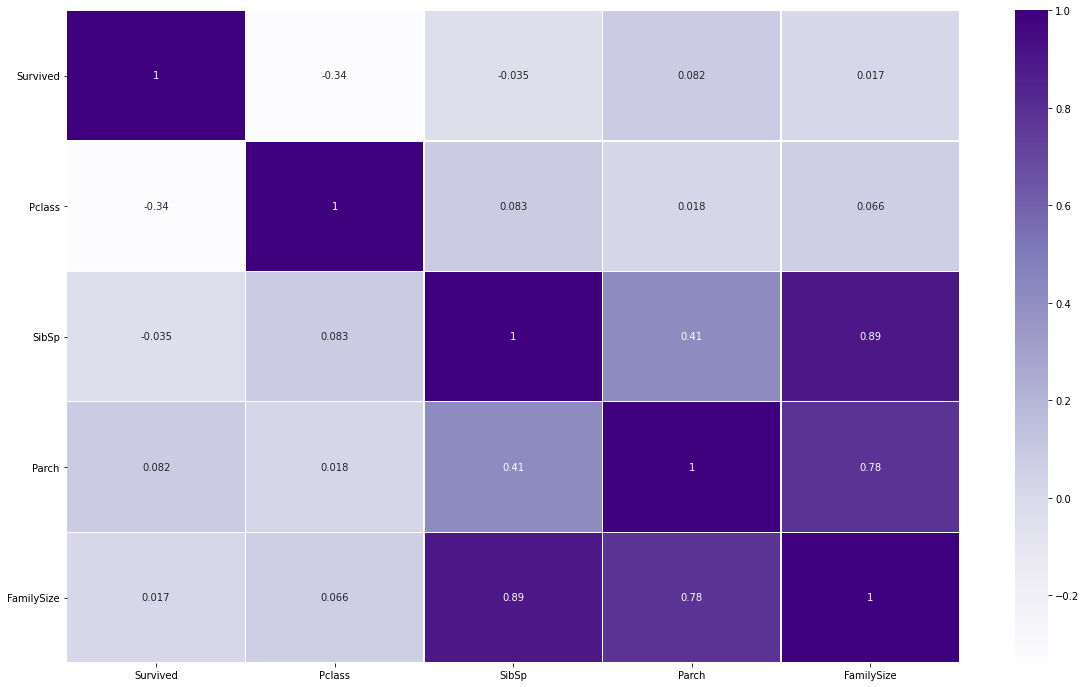

In [37]:
sns.heatmap(train.corr(), annot=True, cmap='Purples', linewidths=0.2)

fig = plt.gcf()
fig.set_size_inches(20, 12)
plt.show()

## Modelling


In [76]:
train_X = train_df.drop(['Survived'], axis = 1)
train_Y = train_df['Survived']

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier as GBC

model = GBC(random_state = 42)
param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300,400],
              'learning_rate': [0.1, 0.05, 0.01,0.001],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.2,0.1] 
              }

modelf = GridSearchCV(model, param_grid = param_grid, scoring="accuracy", n_jobs= 2, verbose = 1)           

modelf.fit(train_X,train_Y)

# Best score
modelf.best_score_

# Best Estimator
modelf.best_estimator_

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   26.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   57.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 960 out of 960 | elapsed:  2.0min finished


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=0.2, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=100, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [78]:
preds = modelf.predict(test_df)

In [80]:
submissions = pd.DataFrame({'PassengerId': Id, 'Survived' : preds})
submissions.to_csv('Submissions.csv', index = False, header=True)

# submit the file to kaggle
!kaggle competitions submit titanic -f Submissions.csv -m "GBoost Classifier- Colab!"

100% 2.77k/2.77k [00:04<00:00, 582B/s]
Successfully submitted to Titanic: Machine Learning from Disaster